In [1]:
import dataretrieval.nwis as nwis
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Functions

In [2280]:
def repeat_years_return_range(values: np.array, start: str, end: str):
    """Repeat values over years represented in start to end and return subset.
    
    The year after the year in end will be included in case hours are needed to be interpolated on the end.
    
    Interpolate to 15 min increments.

    Parameters
    ----------
    values : np.array
        values to match days of year 1 to 366 (includes leap year)
    start : str
        start date time
    end : str
        end date time
    """
    
    print("calculating mean time series")
    
    if len(values) != 366:
        raise ValueError("values should be 366 to match days of year with leap year.")

    # find years covered by requested dates and then repeated stats for necessary 
    # years coverage
    years = sorted(list(set(pd.date_range(start=start, end=end).year)))
    
    # add one more year on so that final day from user date range will for sure have
    # hours included in the interpolation. Otherwise if the end date is 12-31, it will 
    # not have the hours of that day included.
    years += [years[-1] + 1]
    dfs = []
    for year in years:
        time = pd.date_range(start=f"{year}-1-1", end=f"{year}-12-31")
        if not time[0].is_leap_year:
            values_to_use = np.delete(values, 59)  # drop feb 29 if not leap year
        else:
            values_to_use = values

        df = pd.Series(index=time, data=values_to_use)
        dfs.append(df)
        
    stats_repeated = pd.concat(dfs, axis=0)
    # import pdb; pdb.set_trace()
    temps = stats_repeated.resample("15T").interpolate().loc[start.replace("Z",""):end.replace("Z","")]
    
    return temps


In [2411]:
def extrapolate_rating_curve(ratingDataOrig, extreme_val, which_dir: str):

    dd = 0.01  # resolution of rating curves
    
    # create a linear fit to the last points of the rating curve to use for extrapolation
    if which_dir == "up":
        print(f"max data value: {extreme_val}, max INDEP value is {ratingDataOrig['INDEP'].max()}")
        p = np.polyfit(ratingDataOrig["INDEP"][-10:], ratingDataOrig["DEP"][-10:], 3)
        indep_extension = np.arange(ratingDataOrig["INDEP"].max()+dd, extreme_val+dd, dd).round(2)
        dep_extension = np.polyval(p, indep_extension)
        df_extension = pd.DataFrame(data={"INDEP": indep_extension, "DEP": dep_extension})
        ratingData = pd.concat([ratingDataOrig, df_extension], axis=0)    
        
    elif which_dir == "down":
        print(f"min data value: {extreme_val}, min INDEP value is {ratingDataOrig['INDEP'].min()}")
        # create a linear fit to the last points of the rating curve to use for extrapolation
        p = np.polyfit(ratingDataOrig["INDEP"][:10], ratingDataOrig["DEP"][:10], 3)
        indep_extension = np.arange(extreme_val, ratingDataOrig["INDEP"].min(), dd).round(2)
        if indep_extension[-1] == ratingDataOrig["INDEP"].min():
            indep_extension = np.delete(indep_extension, -1)
        dep_extension = np.polyval(p, indep_extension)
        df_extension = pd.DataFrame(data={"INDEP": indep_extension, "DEP": dep_extension})
        ratingData = pd.concat([df_extension, ratingDataOrig], axis=0)    
        
    return ratingData


find_na_groups

In [2335]:
def find_na_groups(df):
    """
    
    https://stackoverflow.com/questions/29007830/identifying-consecutive-nans-with-pandas

    Parameters
    ----------
    df : _type_
        _description_

    Returns
    -------
    _type_
        _description_

    Raises
    ------
    ValueError
        _description_
    """
    # actual groups of nans
    na_groups = df.notna().cumsum().loc[df.isna()].copy()
    
    # # groups of nans plus one on either side (so we can interpolate)
    # ind_wide = df.shift(periods=-1, fill_value=False).isna() | df.shift(periods=1, fill_value=False).isna()
    # nap1_groups = df.notna().cumsum()[ind_wide]
    
    lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)
    
    dt = df.index[1] - df.index[0]
    # make sure dt's are all equal
    if not all(df.index.to_series().diff()[1:] == dt):
        raise ValueError("delta times in indices are not all equal.")
    
    times_consecutive_na = lengths_consecutive_na*dt
    return na_groups, lengths_consecutive_na, times_consecutive_na


In [2635]:
def find_nap1_groups(df):
    """
    UPDATE
    https://stackoverflow.com/questions/29007830/identifying-consecutive-nans-with-pandas

    Parameters
    ----------
    df : _type_
        _description_

    Returns
    -------
    _type_
        _description_

    Raises
    ------
    ValueError
        _description_
    """
    # actual groups of nans
    # na_groups = df.notna().cumsum()[df.isna()]
    # import pdb; pdb.set_trace()
    # # groups of nans plus one on either side (so we can interpolate)
    ind_wide = df.shift(periods=-1, fill_value=False).isna() | \
               df.isna() | \
               df.shift(periods=1, fill_value=False).isna()
    # ind_wide = df.shift(periods=-1, fill_value=False).isna() | df.shift(periods=1, fill_value=False).isna()
    na_groups = df.notna().cumsum().loc[ind_wide].copy()
    
    lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)
    
    dt = df.index[1] - df.index[0]
    # make sure dt's are all equal
    if not all(df.index.to_series().diff()[1:] == dt):
        raise ValueError("delta times in indices are not all equal.")
    
    times_consecutive_na = lengths_consecutive_na*dt
    return na_groups, lengths_consecutive_na, times_consecutive_na


In [2264]:
def return_nwis_data(station, parameter, start, end):
    data = nwis.get_iv(sites=station, parameterCd=parameter, start=start, end=end)[0]
    if data.index.dtype == "O":
        data.index = pd.to_datetime(data.index, utc=True)
    data = data.tz_convert(None)
    return data
    

In [2474]:
def find_mean_time_series(station: str, start: str, end: str, parameter: str) -> pd.Series:
    """in 15 min intervals

    Parameters
    ----------
    station : str
        _description_
    start : str
        _description_
    end : str
        _description_

    Returns
    -------
    pd.Series
        _description_
    """
    
    # if data is not available at all (outside window of availability) use annual mean
    # Retrieve the statistics
    stats = nwis.get_stats(sites=station, parameterCd=parameter, statReportType="daily", statTypeCd="mean")[0]
    discharge = repeat_years_return_range(stats["mean_va"].values, start, end)
    return discharge


In [2981]:
def estimate_discharge_from_gage_data(station, gage_data, index):
    
    # try to use gage data instead, but need rating curve data to do so
    ratingDataOrig = nwis.get_ratings(site=station, file_type="exsa")[0]

    # create estimate using rating curve and gage height if discharge data not fully available
    if not ratingDataOrig.empty:
        
        # see if rating curve needs to be extrapolated. Maybe have a warning to check the reasonableness of the
        # output in this case
        if gage_data.max() > ratingDataOrig["INDEP"].max():
            print(f"Extrapolating ratingData upward for station {station}.")
            ratingData = extrapolate_rating_curve(ratingDataOrig, gage_data.max(), "up")
            
        else:
            ratingData = ratingDataOrig

        if gage_data.min() < ratingData["INDEP"].min():
            print(f"Extrapolating ratingData downward for station {station}.")

            ratingData2 = extrapolate_rating_curve(ratingData, gage_data.min(), "down")

        else:
            ratingData2 = ratingData
            
        # Do a little rolling mean to smooth the data — sometimes it's really jumpy
        gage_data = gage_data.rolling(window="24H", center=True).mean()

        streamflow_estimate_for_gage_data = ratingData2.set_index("INDEP")["DEP"].loc[gage_data[gage_data.notnull()].round(2)]

        # cap values more than twice the max measured discharge value
        # https://kacv.net/brad/nws/lesson7.html
        ind = streamflow_estimate_for_gage_data > ratingDataOrig["DEP"].max()*2
        if ind.sum() > 0:
            print("Some estimated discharge values from gage data were capped at twice the rating curve max.")
            streamflow_estimate_for_gage_data.loc[ind] = ratingDataOrig["DEP"].max()*2
        
        # cap min values at 0
        ind = streamflow_estimate_for_gage_data < 0
        if ind.sum() > 0:
            print("Some estimated discharge values from gage data were brought to 0.")
            streamflow_estimate_for_gage_data.loc[ind] = 0

        # combine. Use streamflow estimate anywhere discharge_data has nan's
        # streamflow_estimate_for_gage_data.index = data.index
        streamflow_estimate_for_gage_data.index = gage_data[gage_data.notnull()].index
        
        # reindex to full set of indices
        streamflow_estimate_for_gage_data = streamflow_estimate_for_gage_data.reindex(index)
    else:
        streamflow_estimate_for_gage_data = pd.Series(index=index, data=np.nan)
    
    return streamflow_estimate_for_gage_data


In [2982]:
# ndays = 8

def replace_over_with_function(time_series, function, function_inputs, ndays):
    # characterize groups of consecutive nans
    na_groups, lengths_consecutive_na, times_consecutive_na = find_na_groups(time_series)
    
    # only use gage data if consecutive nan's over ndays days. In this case create estimate for full time range
    # (as available) and then use whichever parts of it are needed.
    if times_consecutive_na.max() > pd.Timedelta(f"{ndays} days"):
        # print(f"fill consecutive nan gaps of over {ndays} days with function {function}.")
        
        other_time_series = function(*function_inputs)
                    
        ind = times_consecutive_na.loc[na_groups] > pd.Timedelta(f"{ndays} days")
        ind2 = na_groups.loc[ind.values].index
        print(f"fill consecutive nan gaps of over {ndays} days with function {function}.")
        print(f"Dates replaced: {ind2}.")
        
        time_series.loc[ind2] = other_time_series.loc[ind2]

        # # rolling mean of start and stop of new time series to stick in, to ease transitions
        # time_series.loc[ind2] = time_series.rolling(window=f"{ndays}D", center=True).mean().loc[ind2]

    return time_series


def replace_under_with_interpolation(time_series, ndays):
    # characterize groups of consecutive nans
    na_groups, lengths_consecutive_na, times_consecutive_na = find_na_groups(time_series)

    # import pdb; pdb.set_trace()
    # check for under 2 days gaps for interpolation
    if times_consecutive_na.min() <= pd.Timedelta(f"{ndays} days"):
        # print("interpolation")
        
        # characterize groups of consecutive nans (plus one on either side so we can interpolate!)
        na_groupsp1, lengths_consecutive_nap1, times_consecutive_nap1 = find_nap1_groups(time_series)

        # a little more time since have an extra index on either side of the window, not exact
        ind = times_consecutive_nap1.loc[na_groupsp1] <= pd.Timedelta(f"{ndays+.1} days")
        ind2 = na_groupsp1.loc[ind.values].index
        print(f"fill consecutive nan gaps of under {ndays} days by interpolating.")
        print(f"Dates replaced: {ind2}.")

        # time_series.loc[ind2].interpolate(inplace=True)
        time_series.loc[ind2] = time_series.loc[ind2].interpolate()
    return time_series

    

In [2983]:
def discharge_from_gage_or_mean(station: str, start: str, end: str, ndays):

    # Read in gage data
    data = return_nwis_data(station, "00065", start, end)
    print("Accessed gage data.")

    # if empty use mean data for discharge
    if data.empty:
        print("Gage dataset is empty. Use mean time series.")
        discharge_mean = find_mean_time_series(station, start, end, "00060")
        return discharge_mean
        
    # Make sure there is a row for every 15 min in the time range
    index = pd.date_range(start.replace("Z",""), end.replace("Z",""), freq="15T")
    data = data.reindex(index)
   
    # Fill ice flags with 0s
    flags = (data["00065_cd"] == "P, Ice") | (data["00065_cd"] == "A, Ice")
    if flags.any():
        print("Replacing gage values flagged as iced with nan.")
        data.loc[flags,:] = 0.0
    
    # Fill Eqp flags with nans (to be filled in later)
    flags = (data["00065_cd"] == "P, Eqp") | (data["00065_cd"] == "A, Eqp")
    if flags.any():
        print("Replacing gage values flagged as equipment values with nan.")
        data.loc[flags,:] = np.nan
    
    # Calculate estimate
    discharge_estimate = estimate_discharge_from_gage_data(station, data.loc[:,"00065"], index)
    
    discharge_estimate = replace_over_with_function(discharge_estimate.copy(), find_mean_time_series, (station, start, end, "00060"), ndays)
    
    discharge_estimate = replace_under_with_interpolation(discharge_estimate.copy(), ndays)

    return discharge_estimate
        

In [2988]:
def process_discharge(discharge_data, window):
    
    print("processing final discharge data\n")

    # average to hourly
    dischargeh = discharge_data.groupby(pd.Grouper(freq='1H')).mean("numeric_only")

    # convert from cubic feet per second to cubic meters per second
    dischargeh *= 0.3048**3

    # messes up the end points
    # # Do a little rolling mean to smooth the data — sometimes it's really jumpy
    # # 3 hours is 3 data points
    # 24 hours is 24*4 data points
    dischargeh = dischargeh.rolling(window=window, center=True).mean()
    # dischargeh = dischargeh.rolling(window=3, center=True).mean()
    
    # fill in nan's if less than 8 days on front or back
    dischargeh = dischargeh.interpolate(method="ffill", limit=8*24*4)
    dischargeh = dischargeh.interpolate(method="bfill", limit=8*24*4)
    
    return dischargeh


def process_temp(data, window):
    
    print("processing final temp data\n")
        
    # bump temps below 1 up to 1 to match NOAA file
    data.loc[data<1] = 1
     
    # average to hourly
    temph = data.groupby(pd.Grouper(freq='1H')).mean("numeric_only")

    # messes up the end points
    # # Do a little rolling mean to smooth the data — sometimes it's really jumpy
    # # 4 hours is 4 data points
    temph = temph.rolling(window=window, center=True).mean()
    
    # fill in nan's if less than 8 days on front or back
    temph = temph.interpolate(method="ffill", limit=8*24*4)
    temph = temph.interpolate(method="bfill", limit=8*24*4)
    
    return temph



Discharge function

In [2985]:
def find_discharge(station: str, start: str, end: str, ndays, window=24) -> pd.DataFrame:
    
    print(f"Processing discharge for station {station} from {start} to {end}.")

    if pd.Timedelta(f"{ndays} days") < pd.Timestamp(start) - pd.Timestamp(end):
        raise UserWarning("Time range for file creation is shorter than cutoff for interpolation vs. alternative time series.")
    
    # CHANGE VARIABLE NAMES ONCE UPDATED. Also update function names.
    # Read in streamflow data
    data1 = return_nwis_data(station, "00060", start, end)
    print("Accessed discharge data.")
    
    # Check for different scenarios for streamflow data
    
    # if empty try gage data for full time range
    if data1.empty:
        print("Discharge dataset is empty. Check for gage data or use mean time series.")
        discharge = discharge_from_gage_or_mean(station, start, end, ndays)  # for full time range
        # dischargeh = process_discharge(discharge, window=window)
        # return dischargeh
        
    else:
        
        # there might be missing times in the return index
        # Make sure there is a row for every 15 min in the time range
        index = pd.date_range(start.replace("Z",""), end.replace("Z",""), freq="15T")
        data1 = data1.reindex(index)
            
            
        # are all flags "A" or "P"?
        if ((data1["00060_cd"] == "A") | (data1["00060_cd"] == "P")).all():
            print("All discharge flags are good.")
            discharge = data1.loc[:,"00060"]
            
        else:

            # check for questionable estimated data
            flags = (data1["00060_cd"] == "A, e") | (data1["00060_cd"] == "P, e")
            if flags.any():
                print("Some questionable flags present for discharge data.")
                
                # is there good gage data during estimated times?
                data2 = return_nwis_data(station, "00065", 
                                        data1[flags].index[0].strftime("%Y-%m-%dT%H:%MZ"), 
                                        data1[flags].index[-1].strftime("%Y-%m-%dT%H:%MZ"))
                
                # is there gage data and if so, is it good when flags True? (at least 75%)
                if not data2.empty:
                    if ((data2.loc[flags, "00065_cd"] == "A") | (data2.loc[flags, "00065_cd"] == "P")).sum() > len(data2.loc[flags])*.75:
                        
                        # then fill questionable discharge data with nans
                        data1.loc[flags,:] = np.nan
                        print("There is over 75 percent good gage data for the time range of the questionable flags, so naning out the discharge data to use gage data instead.")
                    
                    # otherwise we are just keeping the questionable data
                    else:
                        print("Keeping the discharge data with questionable flags.")
                    
            # check for bad flag data and fill any with nans
            flags = (data1["00060_cd"] == "P, Ice") | (data1["00060_cd"] == "P, Eqp") | (data1["00060_cd"] == "A, Ice") | (data1["00060_cd"] == "A, Eqp")
            if flags.any():
                print("Replacing discharge values flagged as iced with nan.")
                data1.loc[flags,:] = np.nan
            
            discharge = replace_over_with_function(data1["00060"].copy(), discharge_from_gage_or_mean, (station, start, end, ndays), ndays)
            
            discharge = replace_under_with_interpolation(discharge.copy(), ndays)
    
    dischargeh = process_discharge(discharge, window=window)
    
    # check if there are any nan's left
    if dischargeh.isnull().any():
        print('STILL NANS')

    return dischargeh


In [2063]:
# def find_discharge(station: str, start: str, end: str) -> pd.DataFrame:

#     i = station_list_file.index(station)
#     if station == "15292780":
#         station_use = "15292000"
#         factor = 2
#     else:
#         station_use = station
#         factor = 1

#     data1 = nwis.get_iv(sites=station_use, parameterCd=["00060"], start=start, end=end)[0]
#     if data1.index.dtype == "O":
#         data1.index = pd.to_datetime(data1.index, utc=True)
#     data2 = nwis.get_iv(sites=station_use, parameterCd=["00065"], start=start, end=end)[0]
#     if data2.index.dtype == "O":
#         data2.index = pd.to_datetime(data2.index, utc=True)
#     data = pd.concat([data1,data2], axis=1)    
#     data = data.tz_convert(None)
#     # import pdb; pdb.set_trace()
#     # if data.index.dtype == "O":
#     #     data.index = pd.to_datetime(data.index, utc=True)

#     if data.empty:
#         print(f"Using stats for station {station}")
#         # if data is not available at all (outside window of availability) use annual mean
#         # Retrieve the statistics
#         stats = nwis.get_stats(sites=station_use, parameterCd="00060", statReportType="daily", statTypeCd="mean")[0]
#         dischargeh = repeat_years_return_range(stats["mean_va"].values, start, end)

#     else:
#         if "00060" not in data.columns:
#             data["00060"] = np.nan# pd.NA
#         if "00065" not in data.columns:
#             data["00065"] = np.nan# pd.NA
#         data = data[["00060", "00065"]]
        
#         # Make sure there is a row for every 15 min in the time range
#         index = pd.date_range(start.replace("Z",""), end.replace("Z",""), freq="15T")
#         data = data.reindex(index)

#         # catch all non-data values in data and make sure they are nans
#         data[data == -999999.0] = np.nan# pd.NA
#         # discharge is -26999.973 if iced
#         data.loc[data["00060"] + 26999.973 < 1e-3, "00060"] = pd.NA

#         # this will hold the final combined time series
#         discharge_data = data["00060"]

#         # characterize groups of consecutive nans
#         na_groups, lengths_consecutive_na, times_consecutive_na = find_na_groups(discharge_data)
        
#         # only use gage data if consecutive nan's over 2 days
#         if times_consecutive_na.max() > pd.Timedelta("2 days"):
        
#         # if some values are missing from discharge_data, try to fill in other ways
#         # if discharge_data.isnull().sum() > 0:

#             # try to use gage data instead, but need rating curve data to do so
#             ratingDataOrig = nwis.get_ratings(site=station_use, file_type="exsa")[0]

#             # create estimate using rating curve and gage height if discharge data not fully available
#             if not ratingDataOrig.empty:
                
#                 print(f"Using gage data for station {station}.")
                
#                 # see if rating curve needs to be extrapolated. Maybe have a warning to check the reasonableness of the
#                 # output in this case
#                 if data["00065"].max() > ratingDataOrig["INDEP"].max():
#                     print(f"Extrapolating ratingData upward for station {station}.")
#                     ratingData = extrapolate_rating_curve(ratingDataOrig, data["00065"].max(), "up")
                    
#                 else:
#                     ratingData = ratingDataOrig

#                 if data["00065"].min() < ratingData["INDEP"].min():
#                     print(f"Extrapolating ratingData downward for station {station}.")

#                     ratingData2 = extrapolate_rating_curve(ratingData, data["00065"].min(), "down")

#                 else:
#                     ratingData2 = ratingData
#                 # import pdb; pdb.set_trace()
                
                    
#                 # Do a little rolling mean to smooth the data — sometimes it's really jumpy
#                 data["00065"] = data["00065"].rolling(window="12H", center=True).mean()

#                 streamflow_estimate_for_gage_data = ratingData2.set_index("INDEP")["DEP"].loc[data["00065"][data["00065"].notnull()].round(2)]

#                 # cap values more than twice the max measured discharge value
#                 # https://kacv.net/brad/nws/lesson7.html
#                 ind = streamflow_estimate_for_gage_data > ratingDataOrig["DEP"].max()*2
#                 streamflow_estimate_for_gage_data.loc[ind] = ratingDataOrig["DEP"].max()*2
                
#                 # cap min values at 0
#                 ind = streamflow_estimate_for_gage_data < 0
#                 streamflow_estimate_for_gage_data.loc[ind] = 0

#                 # combine. Use streamflow estimate anywhere discharge_data has nan's
#                 # streamflow_estimate_for_gage_data.index = data.index
#                 streamflow_estimate_for_gage_data.index = data[data["00065"].notnull()].index
                
#                 # reindex to full set of indices
#                 streamflow_estimate_for_gage_data = streamflow_estimate_for_gage_data.reindex(index)
                
#                 # import pdb; pdb.set_trace()
#                 # ONLY USE WHERE LARGE ENOUGH NANS
#                 ind = times_consecutive_na.loc[na_groups] > pd.Timedelta("2 days")
#                 ind2 = na_groups[ind.values].index
#                 discharge_data.loc[ind2] = streamflow_estimate_for_gage_data.loc[ind2]


#                 # for group in na_groups:
#                 #     if times_consecutive_na.loc[group] > pd.Timedelta("2 days"):
#                 #         # data["00060"].loc[na_groups[na_groups == group].index]
#                 #         ind = na_groups[na_groups == group].index
#                 #         # dischargeh.loc[ind] = dischargeh.loc[ind].interpolate()
#                 #         discharge_data.loc[ind] = streamflow_estimate_for_gage_data.loc[ind]
                
#                 # discharge_data.loc[discharge_data.isnull()] = streamflow_estimate_for_gage_data.loc[discharge_data.isnull()]

#         # # convert any leftover nan's to 0
#         # discharge_data[discharge_data.isnull()] = 0.0

#         # average to hourly
#         dischargeh = discharge_data.groupby(pd.Grouper(freq='1H')).mean("numeric_only")

#     # convert from cubic feet per second to cubic meters per second
#     dischargeh *= 0.3048**3
#     # import pdb; pdb.set_trace()
#     # characterize groups of consecutive nans (plus one on either side so we can interpolate!)
#     # na_groups, lengths_consecutive_na, times_consecutive_na = find_na_groups(dischargeh)
#     na_groupsp1, lengths_consecutive_nap1, times_consecutive_nap1 = find_nap1_groups(dischargeh)

#     # only interpolate if consecutive nan's less than 2 days
#     if times_consecutive_nap1.max() <= pd.Timedelta("2.1 days"):

#         ind = times_consecutive_nap1.loc[na_groupsp1] <= pd.Timedelta("2.1 days")
#         ind2 = na_groupsp1[ind.values].index
#         dischargeh.loc[ind2] = dischargeh.loc[ind2].interpolate()

#         # ind = times_consecutive_na.loc[na_groupsp1] <= pd.Timedelta("2 days")
#         # ind2 = na_groupsp1[ind.values].index
#         # # data["00060"].loc[ind2] = data["00060"].loc[ind2].interpolate()

#         # data["00060"].loc[ind2].interpolate()
        
#         # for group in na_groups:
#         #     if times_consecutive_na.loc[group] <= pd.Timedelta("2 days"):
#         #         # data["00060"].loc[na_groups[na_groups == group].index]
#         #         ind = na_groups[na_groups == group].index
#         #         dischargeh.loc[ind] = dischargeh.loc[ind].interpolate()
#         #         # dischargeh = dischargeh.interpolate()
            
#         # # LOOP OVER NAN GROUPS TO DO THIS
#         # dischargeh = dischargeh.interpolate()

#     # # fill in nan's if less than 2 days
#     # dischargeh = dischargeh.interpolate(method="ffill", limit=2*24)
#     # import pdb; pdb.set_trace()

#     # # If there are still nan's, fill with 0s
#     # dischargeh = dischargeh.fillna(0)

#     # messes up the end points
#     # # Do a little rolling mean to smooth the data — sometimes it's really jumpy
#     # # 3 hours is 3 data points
#     dischargeh = dischargeh.rolling(window=3, center=True).mean()
    
#     # fill in nan's if less than 1 hour on front or back
#     dischargeh = dischargeh.interpolate(method="ffill", limit=4)
#     dischargeh = dischargeh.interpolate(method="bfill", limit=4)
    
#     # multiply factor
#     dischargeh *= factor

#     # apply sign
#     dischargeh *= river_sign[i]
    
#     # DO THIS LATER
#     # # divide by the number of cells river is represented by
#     # dischargeh /= station_list_file.count(station)
    
#     return dischargeh

Temperature function

In [2986]:
def find_temp(station: str, start: str, end: str, ndays, window=4) -> pd.DataFrame:
    
    print(f"Processing temp for station {station} from {start} to {end}.")

    if pd.Timedelta(f"{ndays} days") < pd.Timestamp(start) - pd.Timestamp(end):
        raise UserWarning("Time range for file creation is shorter than cutoff for interpolation vs. alternative time series.")
    
    data = return_nwis_data(station, "00010", start, end)
    print("Accessed temp data.")

    if station == "15239900":
        print("this station has temp data for several years but the stats don't contain a realistic mean so we have to calculate it ourselves")
        start_local = "2018-4-22T00:00Z"
        end_local = "2023-3-1T00:00Z"
        data = nwis.get_iv(sites="15239900", parameterCd="00010", start=start_local, end=end_local)[0]
        if data.index.dtype == "O":
            data.index = pd.to_datetime(data.index, utc=True)
        data = data.tz_convert(None)

        # catch all non-data values in data and make sure they are nans
        data["00010"] = data["00010"].where(data["00010"] != -999999.0, np.nan)        
        
        # get mean temps by day of year
        vals = data["00010"].groupby(data.index.dayofyear).mean()
        
        temps = repeat_years_return_range(vals.values, start, end)
 

    elif data.empty:
        print("Temp dataset is empty. Use mean time series.")
        # print(f"Using stats for station {station}")
        # if data is not available at all (outside window of availability) use annual mean
        # Retrieve the statistics
        temps = find_mean_time_series(station, start, end, "00010")
        # stats = nwis.get_stats(sites=station, parameterCd="00010", statReportType="daily", statTypeCd="mean")[0]
        # temps = repeat_years_return_range(stats["mean_va"].values, start, end)
        
    else:

        # this will hold the final combined time series
        temps = data["00010"].copy()
        # name will break groupby since starts with 0
        # https://github.com/pandas-dev/pandas/issues/51818
        temps.name = None

        # catch all non-data values in data and make sure they are nans
        temps = temps.where(temps != -999999.0, np.nan)
        
        # might be missing data
        index = pd.date_range(start.replace("Z",""), end.replace("Z",""), freq="15T")
        temps = temps.reindex(index)

        # replace long gaps with mean signal
        temps = replace_over_with_function(temps.copy(), find_mean_time_series, (station, start, end, "00010"), ndays)
        
        temps = replace_under_with_interpolation(temps.copy(), ndays)

    # processing
    temph = process_temp(temps, window=window)
   
    # check if there are any nan's left
    if temph.isnull().any():
        print('STILL NANS')

    # # If there are still nan's, fill with 1s
    # temps = temps.fillna(1)
        
    return temph


In [2733]:
# start = "2013-01-1T00:00Z"
# end = "2013-12-31T00:00Z"

start, end = '2022-12-14T18:00Z', '2022-12-18T01:00Z'


# discharge stations
stations = ['15276000', '15290000', '15271000', '15239900', '15281000', '15295700',
            '15239070', '15275100', '15266300', '15284000', '15292000', '15274600']

station_discharge, station_temp = {}, {}
# for station in temp_stations.values():
#     print(station)
#     station_temp[station] = find_temp(station, start, end)

for station in discharge_stations.values():
    print(station)
    station_discharge[station] = find_discharge(station, start, end, ndays=8)


15276000
fill over 2 days with function
Using gage data for station 15276000.
Extrapolating ratingData upward for station 15276000.
max data value: 8.91, max INDEP value is 7.15
15290000
fill over 2 days with function
Using gage data for station 15290000.
15271000
fill over 2 days with function
Using gage data for station 15271000.
15239900
fill over 2 days with function
calculating mean time series
15281000
calculating mean time series
15295700
15239070
fill over 2 days with function
Using gage data for station 15239070.
15275100
fill over 2 days with function
Using gage data for station 15275100.
15266300
fill over 2 days with function
Using gage data for station 15266300.
15284000
fill over 2 days with function
Using gage data for station 15284000.
Extrapolating ratingData downward for station 15284000.
min data value: 0.0, min INDEP value is 0.1
15292000
fill over 2 days with function
Using gage data for station 15292000.
Extrapolating ratingData downward for station 15292000.
min 

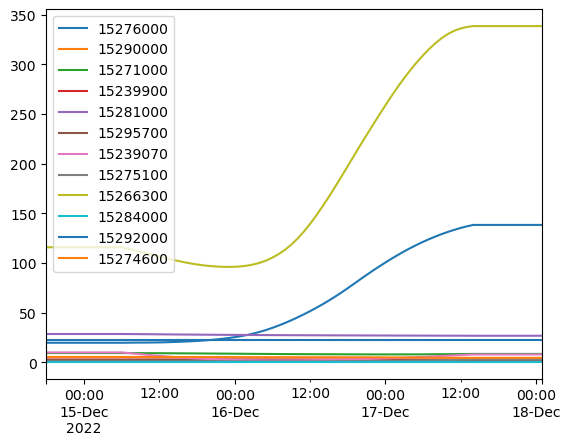

In [2736]:
for station in discharge_stations.values():
    station_discharge[station].plot(label=station)
plt.legend()


fill over 2 days with function
calculating mean time series


<AxesSubplot:>

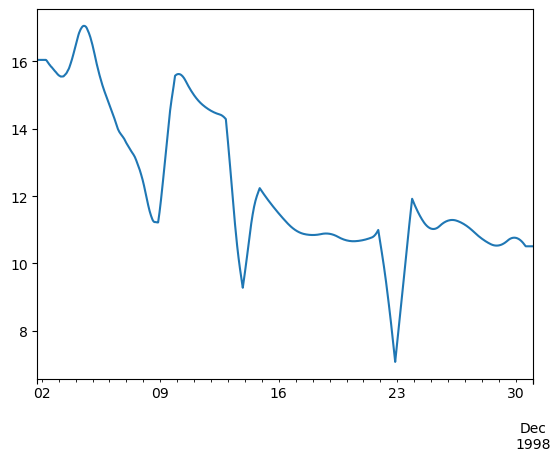

In [2752]:
start, end = '1998-11-1T18:00Z', '1998-12-1T01:00Z'
df = find_discharge("15271000", start, end, ndays=2)
df.plot()

<AxesSubplot:>

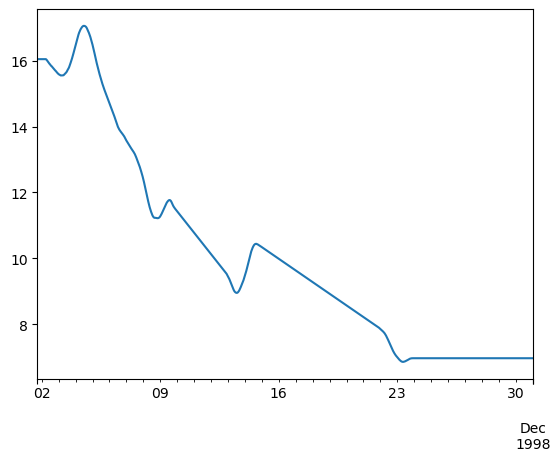

In [2753]:
start, end = '1998-11-1T18:00Z', '1998-12-1T01:00Z'
df = find_discharge("15271000", start, end, ndays=8)
df.plot()

In [2735]:
df[df.isnull()]

Series([], Freq: H, Name: 00060, dtype: float64)

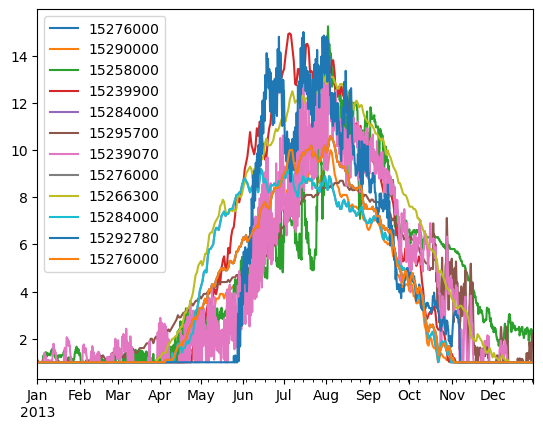

In [2671]:
for station in temp_stations.values():
    station_temp[station].plot(label=station)
plt.legend()


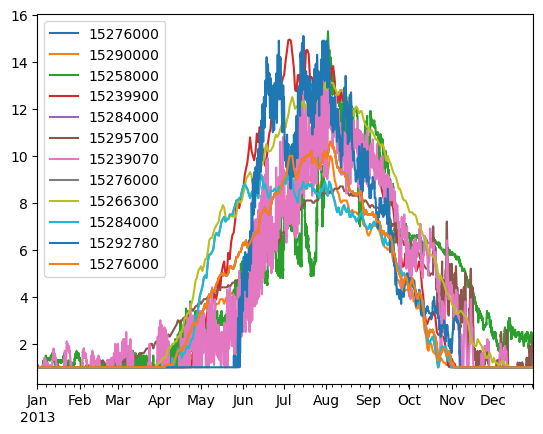

In [2641]:
for station in temp_stations.values():
    station_temp[station].plot(label=station)
plt.legend()


In [2654]:
start = "1998-1-1T01:00Z"
end = "1998-12-31T23:00Z"
station = "15266300"
df = find_discharge(station, start, end)
df

fill over 8 days with function
calculating mean time series


1998-01-01 01:00:00    57.151683
1998-01-01 02:00:00    57.151683
1998-01-01 03:00:00    57.151683
1998-01-01 04:00:00    57.151683
1998-01-01 05:00:00    57.151683
                         ...    
1998-12-31 19:00:00    59.362692
1998-12-31 20:00:00    59.362692
1998-12-31 21:00:00    59.362692
1998-12-31 22:00:00    59.362692
1998-12-31 23:00:00    59.362692
Freq: H, Name: 00060, Length: 8759, dtype: float64

<AxesSubplot:>

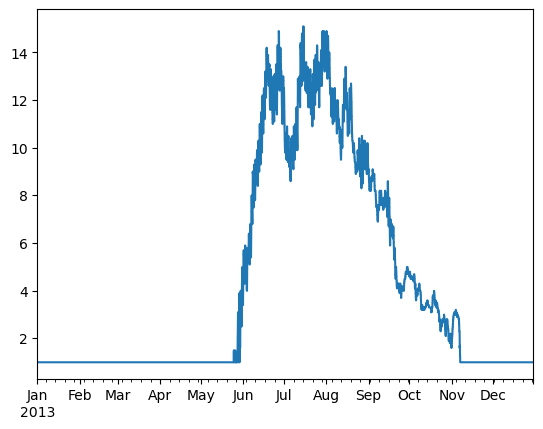

In [2643]:
station_temp["15292780"].plot()

tests

fill over 8 days with function
calculating mean time series


<AxesSubplot:>

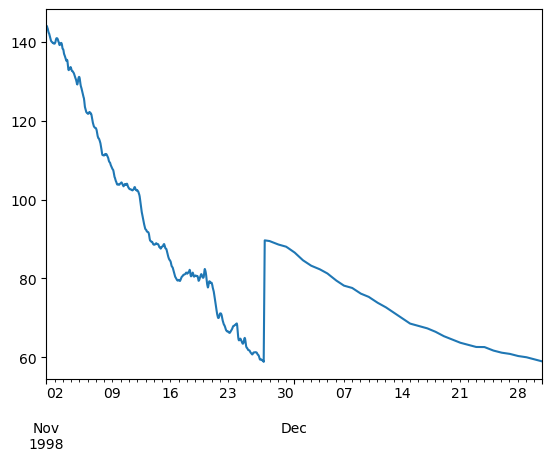

In [2646]:
start = "1998-11-1T00:00Z"
end = "1998-12-31T00:00Z"
station = "15266300"
df = find_discharge(station, start, end)
df.plot()

fill over 8 days with function
calculating mean time series


<AxesSubplot:>

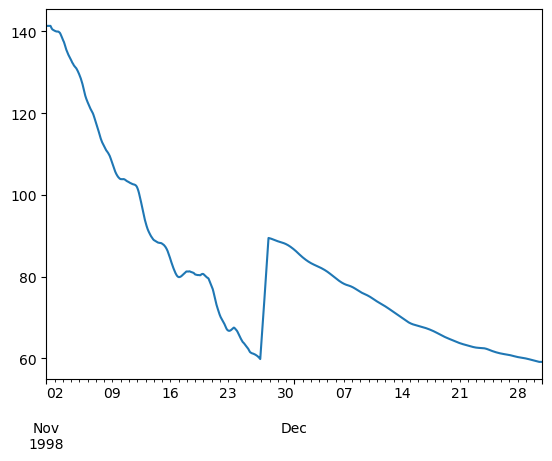

In [2657]:
start = "1998-11-1T00:00Z"
end = "1998-12-31T00:00Z"
station = "15266300"
df = find_discharge(station, start, end)
df.plot()

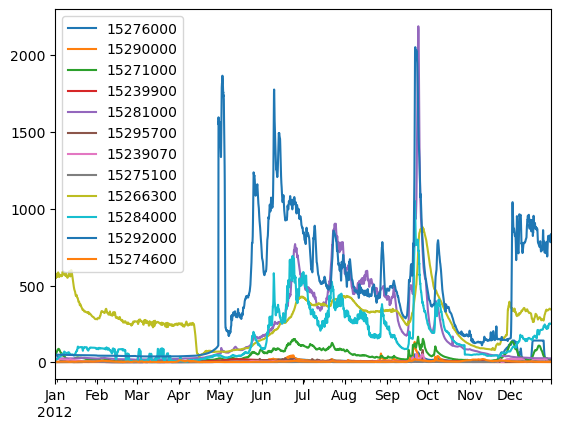

In [2452]:
for station in stations:
    station_discharge[station].plot(label=station)
plt.legend()


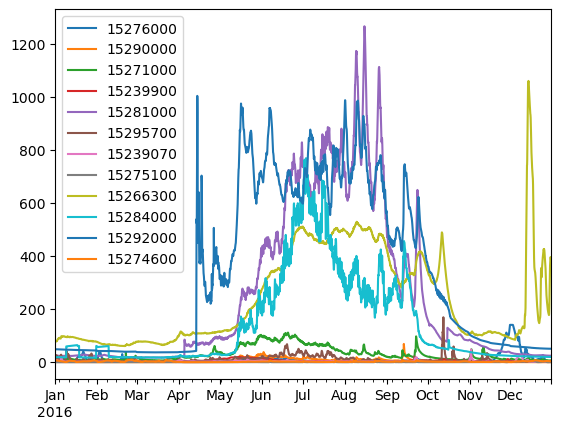

In [2450]:
for station in stations:
    station_discharge[station].plot(label=station)
plt.legend()


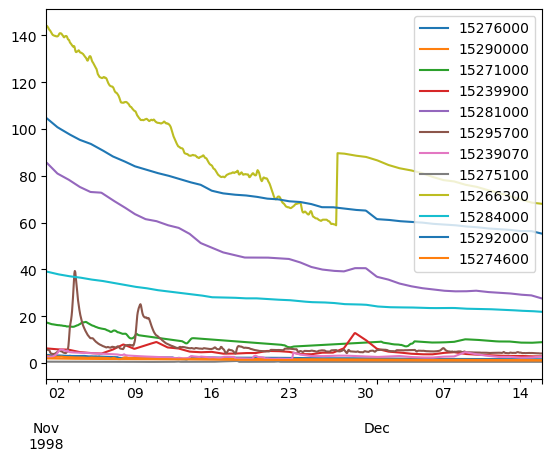

In [2406]:
for station in stations:
    station_discharge[station].plot(label=station)
plt.legend()


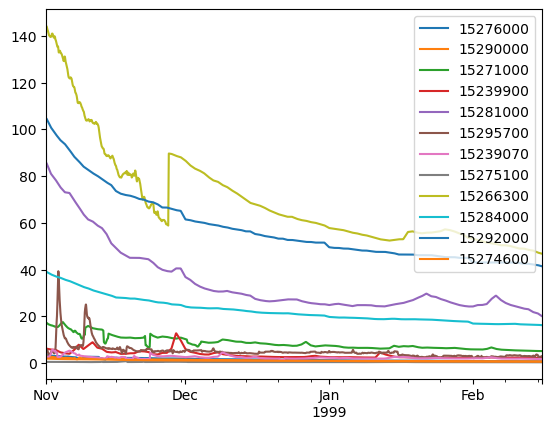

In [ ]:
for station in stations:
    station_discharge[station].plot(label=station)
plt.legend()


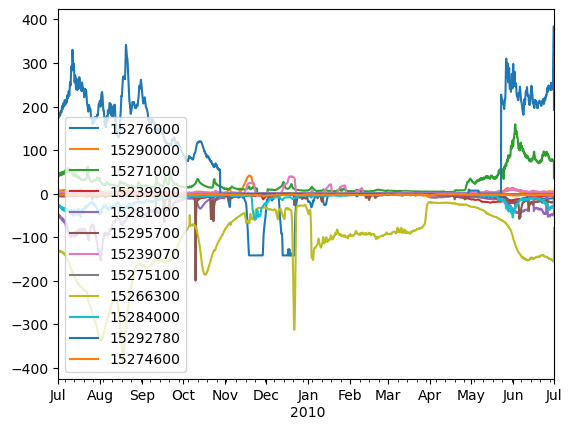

In [2039]:
for station in stations:
    station_discharge[station].plot(label=station)
plt.legend()


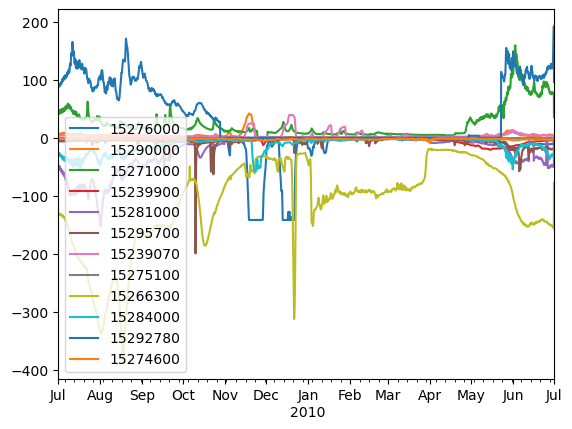

In [2036]:
for station in stations:
    station_discharge[station].plot(label=station)
plt.legend()


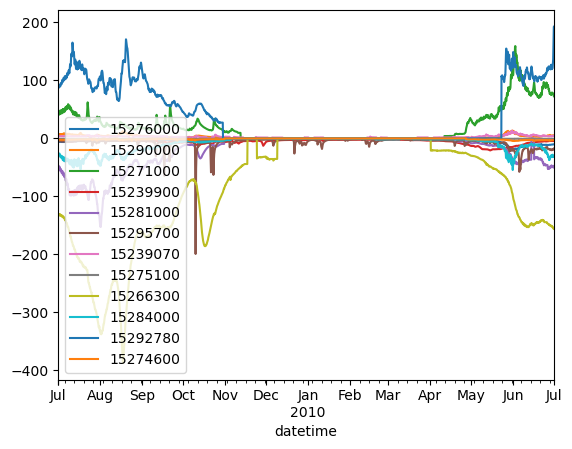

In [1824]:
for station in stations:
    station_discharge[station].plot(label=station)
plt.legend()


Using gage data for station 15266300.


<AxesSubplot:xlabel='datetime'>

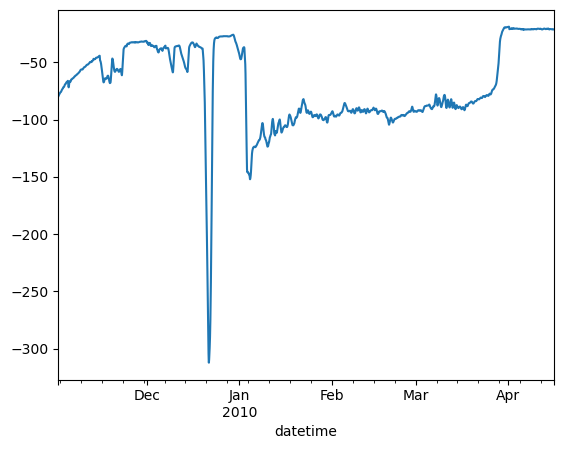

In [1828]:
# gage data used
df = find_discharge("15266300", "2009-11-1", "2010-4-15")
df.plot()

<AxesSubplot:xlabel='datetime'>

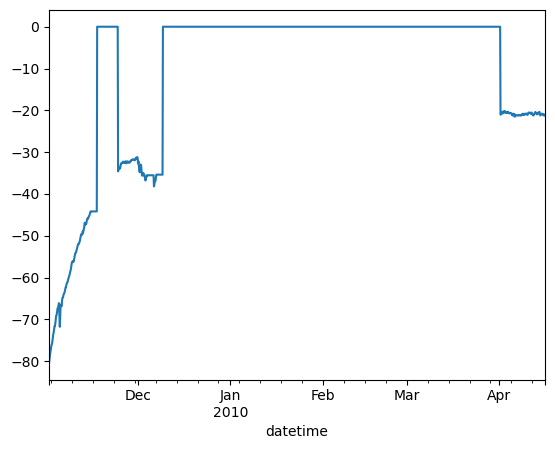

In [1825]:
# no gage data used
df = find_discharge("15266300", "2009-11-1", "2010-4-15")
df.plot()

Using gage data for station 15266300.


<AxesSubplot:xlabel='datetime'>

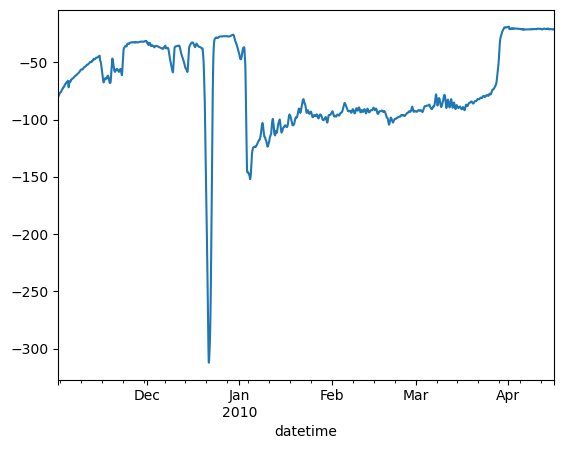

In [1905]:
# after code changes counting consecutive nans
df = find_discharge("15266300", "2009-11-1", "2010-4-15")
df.plot()

Using gage data for station 15266300.


<AxesSubplot:>

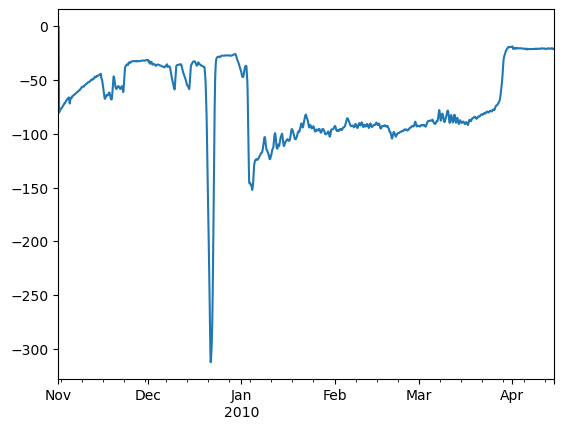

In [2034]:
# after code changes counting consecutive nans
df = find_discharge("15266300", "2009-11-1", "2010-4-15")
df.plot()

<AxesSubplot:xlabel='datetime'>

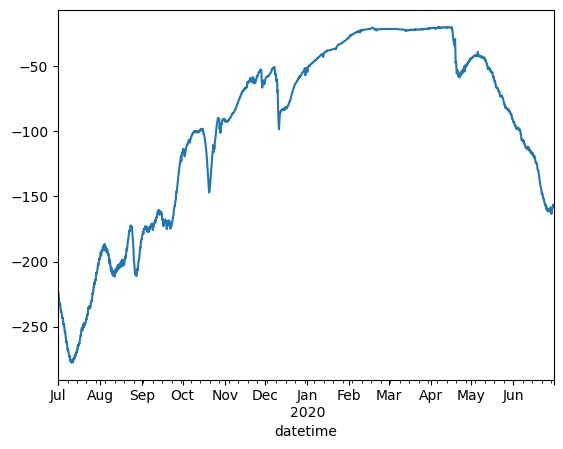

In [1826]:
start = "2019-07-1T00:00Z"
end = "2020-7-1T00:00Z"
df = find_discharge("15266300", start, end)
df.plot()

<AxesSubplot:xlabel='datetime'>

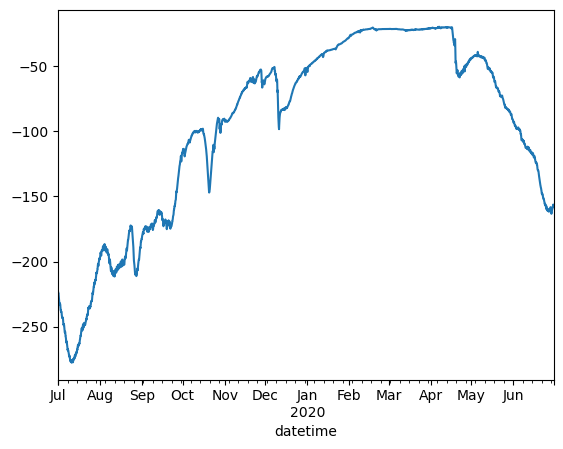

In [1904]:
# after code changes counting consecutive nans
start = "2019-07-1T00:00Z"
end = "2020-7-1T00:00Z"
df = find_discharge("15266300", start, end)
df.plot()

In [1960]:
    station_use = "15266300"
    data1 = nwis.get_iv(sites=station_use, parameterCd=["00060"], start=start, end=end)[0]
    if data1.index.dtype == "O":
        data1.index = pd.to_datetime(data1.index, utc=True)
    data2 = nwis.get_iv(sites=station_use, parameterCd=["00065"], start=start, end=end)[0]
    if data2.index.dtype == "O":
        data2.index = pd.to_datetime(data2.index, utc=True)
    data = pd.concat([data1,data2], axis=1)    
    data = data.tz_convert(None)
    # import pdb; pdb.set_trace()
    # if data.index.dtype == "O":
    #     data.index = pd.to_datetime(data.index, utc=True)

    # if data.empty:
    #     print(f"Using stats for station {station}")
    #     # if data is not available at all (outside window of availability) use annual mean
    #     # Retrieve the statistics
    #     stats = nwis.get_stats(sites=station_use, parameterCd="00060", statReportType="daily", statTypeCd="mean")[0]
    #     dischargeh = repeat_years_return_range(stats["mean_va"].values, start, end)

    # else:
    #     if "00060" not in data.columns:
    #         data["00060"] = np.nan# pd.NA
    #     if "00065" not in data.columns:
    #         data["00065"] = np.nan# pd.NA
    #     data = data[["00060", "00065"]]

    #     # catch all non-data values in data and make sure they are nans
    #     data[data == -999999.0] = np.nan# pd.NA
    #     # discharge is -26999.973 if iced
    #     data.loc[data["00060"] + 26999.973 < 1e-3, "00060"] = pd.NA

    #     # this will hold the final combined time series
    #     discharge_data = data["00060"]
        
    #     # if some values are missing from discharge_data, try to fill in other ways
    #     if discharge_data.isnull().sum() > 0:

    #         # try to use gage data instead, but need rating curve data to do so
    #         ratingDataOrig = nwis.get_ratings(site=station_use, file_type="exsa")[0]

    #         # create estimate using rating curve and gage height if discharge data not fully available
    #         if not ratingDataOrig.empty:
                
    #             print(f"Using gage data for station {station}.")
                
    #             # see if rating curve needs to be extrapolated. Maybe have a warning to check the reasonableness of the
    #             # output in this case
    #             if data["00065"].max() > ratingDataOrig["INDEP"].max():
    #                 print(f"Extrapolating ratingData upward for station {station}.")
    #                 ratingData = extrapolate_rating_curve(ratingDataOrig, data["00065"].max(), "up")
                    
    #             else:
    #                 ratingData = ratingDataOrig

    #             if data["00065"].min() < ratingData["INDEP"].min():
    #                 print(f"Extrapolating ratingData downward for station {station}.")

    #                 ratingData2 = extrapolate_rating_curve(ratingData, data["00065"].min(), "down")

    #             else:
    #                 ratingData2 = ratingData
    #             # import pdb; pdb.set_trace()
                
                    
    #             # Do a little rolling mean to smooth the data — sometimes it's really jumpy
    #             data["00065"] = data["00065"].rolling(window="12H", center=True).mean()

    #             streamflow_estimate_for_gage_data = ratingData2.set_index("INDEP")["DEP"].loc[data["00065"][data["00065"].notnull()].round(2)]

    #             # cap values more than twice the max measured discharge value
    #             # https://kacv.net/brad/nws/lesson7.html
    #             ind = streamflow_estimate_for_gage_data > ratingDataOrig["DEP"].max()*2
    #             streamflow_estimate_for_gage_data.loc[ind] = ratingDataOrig["DEP"].max()*2
                
    #             # cap min values at 0
    #             ind = streamflow_estimate_for_gage_data < 0
    #             streamflow_estimate_for_gage_data.loc[ind] = 0

    #             # combine. Use streamflow estimate anywhere discharge_data has nan's
    #             streamflow_estimate_for_gage_data.index = data[data["00065"].notnull()].index
    #             discharge_data.loc[discharge_data.isnull()] = streamflow_estimate_for_gage_data.loc[discharge_data.isnull()]

    #     # convert any leftover nan's to 0
    #     discharge_data[discharge_data.isnull()] = 0.0

    #     # average to hourly
    #     dischargeh = discharge_data.groupby(pd.Grouper(freq='1H')).mean("numeric_only")

    # # convert from cubic feet per second to cubic meters per second
    # dischargeh *= 0.3048**3

    # # fill in nan's if less than 2 days
    # dischargeh = dischargeh.interpolate(method="ffill", limit=2*24)

    # # If there are still nan's, fill with 0s
    # dischargeh = dischargeh.fillna(0)



In [1961]:
index = pd.date_range(start.replace("Z",""), end.replace("Z",""), freq="15T")
data = data.reindex(index)
na_groups, lengths_consecutive_na, times_consecutive_na = find_na_groups(data["00060"])

In [1958]:

# # characterize groups of consecutive nans
# na_groups, lengths_consecutive_na, times_consecutive_na = find_na_groups(data["00060"])

# only interpolate if consecutive nan's less than 2 days
if times_consecutive_na.min() <= pd.Timedelta("2 days"):
    # ind = times_consecutive_na.loc[na_groups] <= pd.Timedelta("2 days")
    # na_groups[ind.values].index
    
    for group in na_groups:
        if times_consecutive_na.loc[group] <= pd.Timedelta("2 days"):
            # data["00060"].loc[na_groups[na_groups == group].index]
            ind = na_groups[na_groups == group].index
            data["00060"].loc[ind] = data["00060"].loc[ind].interpolate()


/var/folders/mf/by34w_vj643fb7dvt5skt7p40000gn/T/ipykernel_54677/1294057543.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["00060"].loc[ind] = data["00060"].loc[ind].interpolate()


In [1992]:
df = data["00060"].copy()
df

2009-07-01 00:00:00     9360.0
2009-07-01 00:15:00     9430.0
2009-07-01 00:30:00     9430.0
2009-07-01 00:45:00     9390.0
2009-07-01 01:00:00     9390.0
                        ...   
2010-06-30 23:00:00    11000.0
2010-06-30 23:15:00        NaN
2010-06-30 23:30:00        NaN
2010-06-30 23:45:00        NaN
2010-07-01 00:00:00        NaN
Freq: 15T, Name: 00060, Length: 35041, dtype: float64

In [1994]:
df.notna().cumsum(), df.isna()

(2009-07-01 00:00:00        1
 2009-07-01 00:15:00        2
 2009-07-01 00:30:00        3
 2009-07-01 00:45:00        4
 2009-07-01 01:00:00        5
                        ...  
 2010-06-30 23:00:00    22941
 2010-06-30 23:15:00    22941
 2010-06-30 23:30:00    22941
 2010-06-30 23:45:00    22941
 2010-07-01 00:00:00    22941
 Freq: 15T, Name: 00060, Length: 35041, dtype: int64,
 2009-07-01 00:00:00    False
 2009-07-01 00:15:00    False
 2009-07-01 00:30:00    False
 2009-07-01 00:45:00    False
 2009-07-01 01:00:00    False
                        ...  
 2010-06-30 23:00:00    False
 2010-06-30 23:15:00     True
 2010-06-30 23:30:00     True
 2010-06-30 23:45:00     True
 2010-07-01 00:00:00     True
 Freq: 15T, Name: 00060, Length: 35041, dtype: bool)

In [2011]:
(df.shift(periods=-1, fill_value=False).isna() | df.shift(periods=1, fill_value=False).isna()).sum()

12109

In [2009]:
df.isna().sum()

12100

In [2013]:
ind_wide = df.shift(periods=-1, fill_value=False).isna() | df.shift(periods=1, fill_value=False).isna()
df.notna().cumsum()[ind_wide]

2009-10-05 23:45:00     9312
2009-10-06 00:00:00     9312
2009-10-06 00:15:00     9312
2009-10-06 00:30:00     9312
2009-10-06 00:45:00     9312
                       ...  
2010-06-30 23:00:00    22941
2010-06-30 23:15:00    22941
2010-06-30 23:30:00    22941
2010-06-30 23:45:00    22941
2010-07-01 00:00:00    22941
Name: 00060, Length: 12109, dtype: int64

In [2012]:
na_groups = df.notna().cumsum()[df.isna()]  # CAN I ADD HERE TO GET NEARBY VALUES?
na_groups

2009-10-06 00:00:00     9312
2009-10-06 00:15:00     9312
2009-10-06 00:30:00     9312
2009-10-06 00:45:00     9312
2009-11-15 09:00:00    13184
                       ...  
2010-04-01 07:45:00    14240
2010-06-30 23:15:00    22941
2010-06-30 23:30:00    22941
2010-06-30 23:45:00    22941
2010-07-01 00:00:00    22941
Name: 00060, Length: 12100, dtype: int64

In [1979]:
na_groups == group

2009-10-06 00:00:00    False
2009-10-06 00:15:00    False
2009-10-06 00:30:00    False
2009-10-06 00:45:00    False
2009-11-15 09:00:00    False
                       ...  
2010-04-01 07:45:00    False
2010-06-30 23:15:00     True
2010-06-30 23:30:00     True
2010-06-30 23:45:00     True
2010-07-01 00:00:00     True
Name: 00060, Length: 12100, dtype: bool

In [1980]:
times_consecutive_na.loc[na_groups[0]] <= pd.Timedelta("2 days")
ind = na_groups[na_groups == group].index
# data["00060"].loc[ind].interpolate()
ind

DatetimeIndex(['2010-06-30 23:15:00', '2010-06-30 23:30:00',
               '2010-06-30 23:45:00', '2010-07-01 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [1984]:
data["00060"].index.get_loc(ind[0]), data["00060"].index.get_loc(ind[-1])

(35037, 35040)

In [1991]:
istart = data["00060"].index.get_loc(ind[0]) - 1
iend = data["00060"].index.get_loc(ind[-1]) + 2
data["00060"].iloc[istart:iend]

2010-06-30 23:00:00    11000.0
2010-06-30 23:15:00        NaN
2010-06-30 23:30:00        NaN
2010-06-30 23:45:00        NaN
2010-07-01 00:00:00        NaN
Freq: 15T, Name: 00060, dtype: float64

In [1971]:
ind = times_consecutive_na.loc[na_groups] <= pd.Timedelta("2 days")
ind2 = na_groups[ind.values].index
data["00060"].loc[ind2] = data["00060"].loc[ind2].interpolate()



/var/folders/mf/by34w_vj643fb7dvt5skt7p40000gn/T/ipykernel_54677/607524901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["00060"].loc[ind2] = data["00060"].loc[ind2].interpolate()


InvalidIndexError: DatetimeIndex(['2010-06-30 23:15:00', '2010-06-30 23:30:00',
               '2010-06-30 23:45:00', '2010-07-01 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [1975]:
ind2[:50]

DatetimeIndex(['2009-10-06 00:00:00', '2009-10-06 00:15:00',
               '2009-10-06 00:30:00', '2009-10-06 00:45:00',
               '2009-12-04 09:00:00', '2009-12-04 09:15:00',
               '2009-12-04 09:30:00', '2009-12-04 09:45:00',
               '2009-12-04 10:00:00', '2009-12-04 10:15:00',
               '2009-12-04 10:30:00', '2009-12-04 10:45:00',
               '2009-12-04 11:00:00', '2009-12-04 11:15:00',
               '2009-12-04 11:30:00', '2009-12-04 11:45:00',
               '2009-12-04 12:00:00', '2009-12-04 12:15:00',
               '2009-12-04 12:30:00', '2009-12-04 12:45:00',
               '2009-12-04 13:00:00', '2009-12-04 13:15:00',
               '2009-12-04 13:30:00', '2009-12-04 13:45:00',
               '2009-12-04 14:00:00', '2009-12-04 14:15:00',
               '2009-12-04 14:30:00', '2009-12-04 14:45:00',
               '2009-12-04 15:00:00', '2009-12-04 15:15:00',
               '2009-12-04 15:30:00', '2009-12-04 15:45:00',
               '2009-12-

In [1977]:
data["00060"].loc[ind2].loc["2009-12-4"]

2009-12-04 09:00:00   NaN
2009-12-04 09:15:00   NaN
2009-12-04 09:30:00   NaN
2009-12-04 09:45:00   NaN
2009-12-04 10:00:00   NaN
2009-12-04 10:15:00   NaN
2009-12-04 10:30:00   NaN
2009-12-04 10:45:00   NaN
2009-12-04 11:00:00   NaN
2009-12-04 11:15:00   NaN
2009-12-04 11:30:00   NaN
2009-12-04 11:45:00   NaN
2009-12-04 12:00:00   NaN
2009-12-04 12:15:00   NaN
2009-12-04 12:30:00   NaN
2009-12-04 12:45:00   NaN
2009-12-04 13:00:00   NaN
2009-12-04 13:15:00   NaN
2009-12-04 13:30:00   NaN
2009-12-04 13:45:00   NaN
2009-12-04 14:00:00   NaN
2009-12-04 14:15:00   NaN
2009-12-04 14:30:00   NaN
2009-12-04 14:45:00   NaN
2009-12-04 15:00:00   NaN
2009-12-04 15:15:00   NaN
2009-12-04 15:30:00   NaN
2009-12-04 15:45:00   NaN
2009-12-04 16:00:00   NaN
2009-12-04 16:15:00   NaN
2009-12-04 16:30:00   NaN
2009-12-04 16:45:00   NaN
2009-12-04 17:00:00   NaN
2009-12-04 17:15:00   NaN
2009-12-04 17:30:00   NaN
2009-12-04 17:45:00   NaN
2009-12-04 18:00:00   NaN
2009-12-04 18:15:00   NaN
2009-12-04 1

<AxesSubplot:>

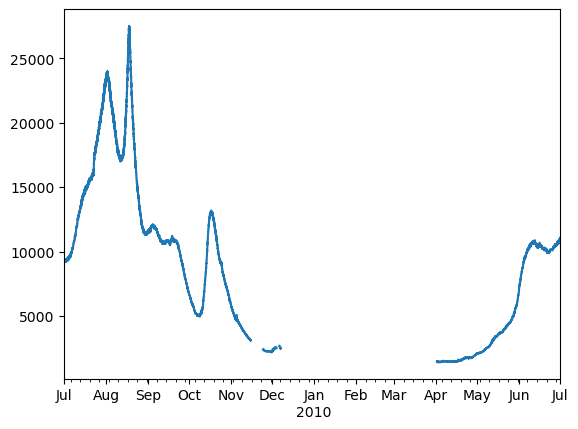

In [1970]:
data["00060"].plot()

<AxesSubplot:>

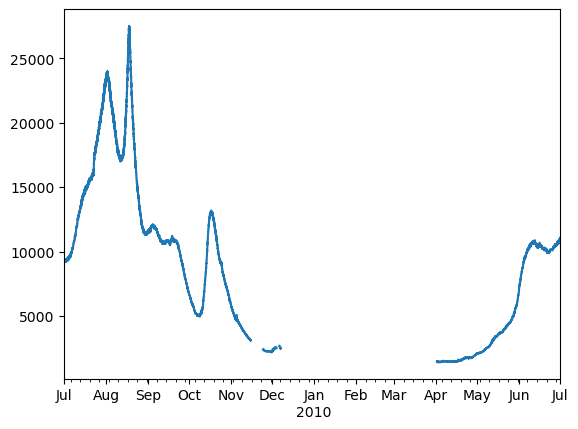

In [1972]:
data["00060"].plot()

In [1959]:
times_consecutive_na.min()

Timedelta('0 days 01:00:00')

In [1957]:
times_consecutive_na.max() <= pd.Timedelta("2 days")

False

In [1938]:
times_consecutive_na.loc[na_groups[0]]

Timedelta('0 days 01:00:00')

In [1945]:
ind = times_consecutive_na.loc[na_groups] <= pd.Timedelta("2 days")
ind

00060
9312      True
9312      True
9312      True
9312      True
13184    False
         ...  
14240    False
22941     True
22941     True
22941     True
22941     True
Name: 00060, Length: 12100, dtype: bool

In [1956]:
na_groups[ind.values].index

DatetimeIndex(['2009-10-06 00:00:00', '2009-10-06 00:15:00',
               '2009-10-06 00:30:00', '2009-10-06 00:45:00',
               '2009-12-04 09:00:00', '2009-12-04 09:15:00',
               '2009-12-04 09:30:00', '2009-12-04 09:45:00',
               '2009-12-04 10:00:00', '2009-12-04 10:15:00',
               ...
               '2009-12-06 07:30:00', '2009-12-06 07:45:00',
               '2009-12-06 08:00:00', '2009-12-06 08:15:00',
               '2009-12-06 08:30:00', '2009-12-06 08:45:00',
               '2010-06-30 23:15:00', '2010-06-30 23:30:00',
               '2010-06-30 23:45:00', '2010-07-01 00:00:00'],
              dtype='datetime64[ns]', length=200, freq=None)

In [1946]:
na_groups

2009-10-06 00:00:00     9312
2009-10-06 00:15:00     9312
2009-10-06 00:30:00     9312
2009-10-06 00:45:00     9312
2009-11-15 09:00:00    13184
                       ...  
2010-04-01 07:45:00    14240
2010-06-30 23:15:00    22941
2010-06-30 23:30:00    22941
2010-06-30 23:45:00    22941
2010-07-01 00:00:00    22941
Name: 00060, Length: 12100, dtype: int64

In [1951]:
na_groups.loc[ind[ind]]#.index

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [1843]:
na_groups.head(15)

datetime
2020-01-15 20:00:00    19092
2020-01-15 20:15:00    19092
2020-01-15 20:30:00    19092
2020-01-15 20:45:00    19092
2020-01-15 21:00:00    19092
2020-01-15 21:15:00    19092
2020-01-15 21:30:00    19092
2020-01-15 22:00:00    19093
2020-01-15 22:15:00    19093
2020-01-15 22:30:00    19093
2020-01-15 22:45:00    19093
2020-01-15 23:00:00    19093
2020-01-15 23:15:00    19093
2020-01-15 23:30:00    19093
2020-01-16 00:00:00    19094
Name: 00060, dtype: int64

In [1842]:
lengths_consecutive_na.head(10)

00060
19092    7
19093    7
19094    7
19095    7
19096    7
19097    7
19098    7
19099    7
19100    7
19101    7
Name: 00060, dtype: int64

In [1860]:
lengths_consecutive_na*dt

00060
19092   0 days 01:45:00
19093   0 days 01:45:00
19094   0 days 01:45:00
19095   0 days 01:45:00
19096   0 days 01:45:00
              ...      
23489   0 days 00:15:00
23557   0 days 00:45:00
23561   0 days 00:15:00
23568   0 days 00:15:00
24037   0 days 00:15:00
Name: 00060, Length: 511, dtype: timedelta64[ns]

In [1859]:
dt = data["00060"].index[1] - data["00060"].index[0]
dt

Timedelta('0 days 00:15:00')

<AxesSubplot:xlabel='datetime'>

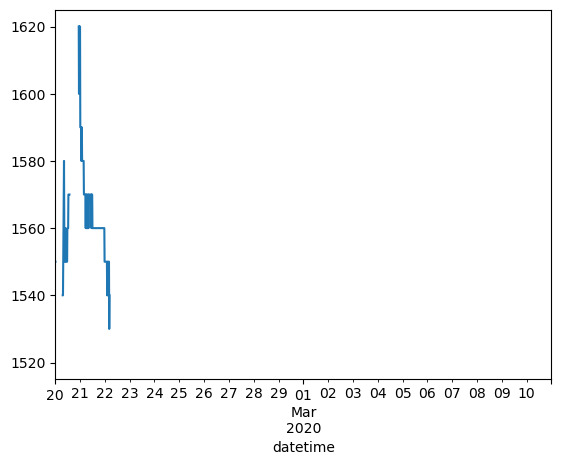

In [1809]:
data["00060"].loc["2020-2-20":"2020-3-10"].plot()

In [1814]:
# data1["00060"].loc["2020-2-20":"2020-3-10"]#.plot(marker=".")
data1["00060"].loc["2020-3-1"]

datetime
2020-03-01 00:30:00+00:00    1530.0
2020-03-01 02:30:00+00:00    1530.0
2020-03-01 04:30:00+00:00    1530.0
2020-03-01 06:30:00+00:00    1530.0
2020-03-01 08:30:00+00:00    1530.0
2020-03-01 10:30:00+00:00    1530.0
2020-03-01 12:30:00+00:00    1530.0
2020-03-01 14:30:00+00:00    1530.0
2020-03-01 16:30:00+00:00    1520.0
2020-03-01 18:30:00+00:00    1520.0
2020-03-01 20:30:00+00:00    1520.0
2020-03-01 22:30:00+00:00    1520.0
Name: 00060, dtype: float64

In [1873]:
pd.DatetimeIndex(["2022-1-1T00:15","2022-1-1T00:45"]).freq = "15T"

ValueError: Inferred frequency None from passed values does not conform to passed frequency 15T

In [1866]:
data1["00060"].index.freq = "15T"


ValueError: Inferred frequency None from passed values does not conform to passed frequency 15T

<AxesSubplot:xlabel='datetime'>

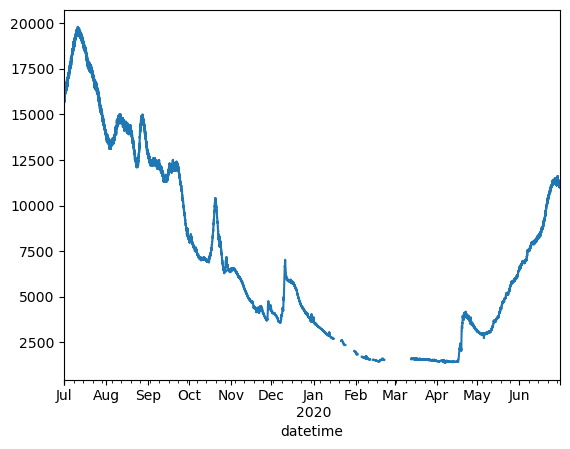

In [1805]:
discharge_data.plot()

<AxesSubplot:xlabel='datetime'>

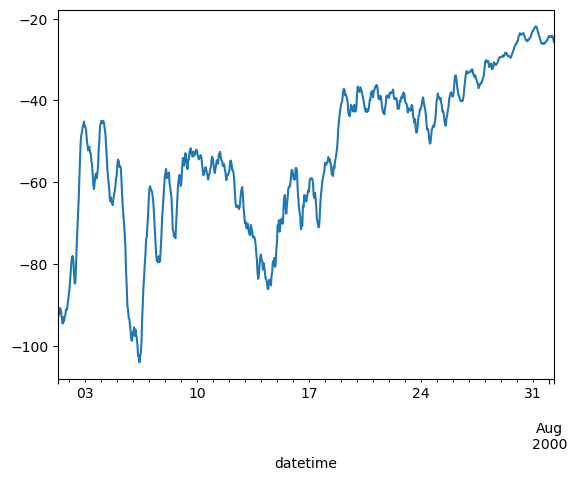

In [1783]:
df = find_discharge("15284000", "2000-7-1", "2000-7-31")
df.plot()

<AxesSubplot:xlabel='datetime'>

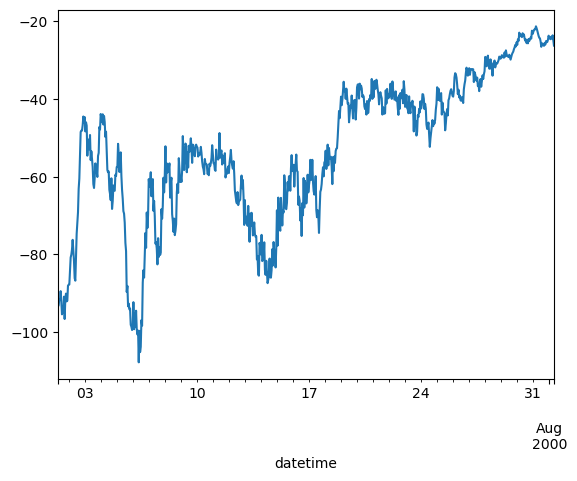

In [1780]:
df = find_discharge("15284000", "2000-7-1", "2000-7-31")
df.plot()

<AxesSubplot:xlabel='datetime'>

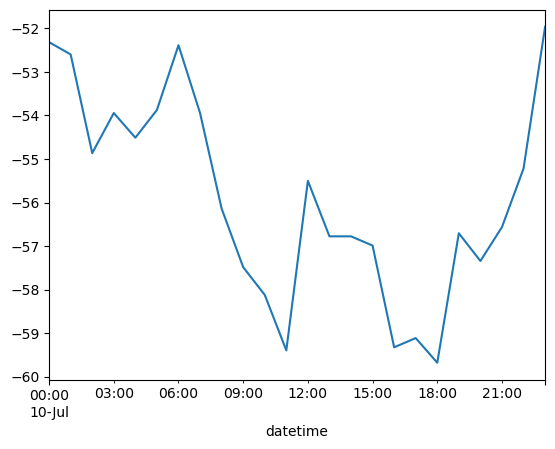

In [1781]:
df.loc["2000-7-10"].plot()

# Example for why I am rolling-mean the gage data

In [1763]:
start = "2010-12-1T00:00Z"
end = "2011-2-1T00:00Z"

station_discharge, station_temp = {}, {}
for station in stations:
    print(station)
    station_discharge[station] = find_discharge(station, start, end)
    # station_temp[station] = find_temp(station, start, end)


15276000
Using gage data for station 15276000.
Extrapolating ratingData upward for station 15276000.
15290000
Using gage data for station 15290000.
15271000
Using gage data for station 15271000.
15239900
Using stats for station 15239900
15281000
Using stats for station 15281000
15295700
Using gage data for station 15295700.
15239070
Using gage data for station 15239070.
15275100
Using gage data for station 15275100.
Extrapolating ratingData downward for station 15275100.
min data value: 1.6, min INDEP value is 1.75
15266300
Using gage data for station 15266300.
15284000
Using gage data for station 15284000.
15292780
Using stats for station 15292780
15274600
Using gage data for station 15274600.


15276000
15290000
15271000
15239900
15281000
15295700
15239070
15275100
15266300
15284000
15292780
15274600


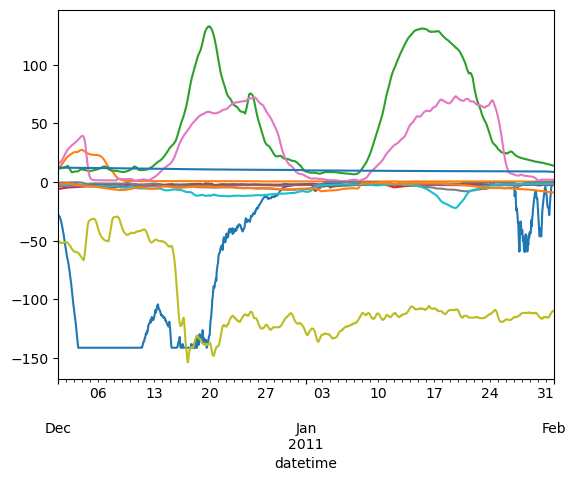

In [1764]:
for station in stations:
    print(station)
    station_discharge[station].plot()

15276000
15290000
15271000
15239900
15281000
15295700
15239070
15275100
15266300
15284000
15292780
15274600


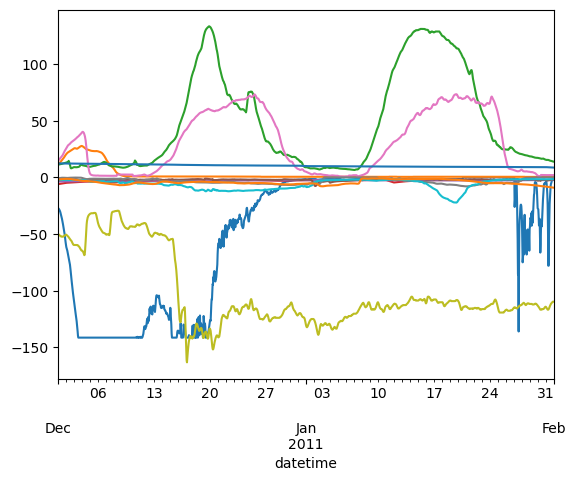

In [1759]:
for station in stations:
    print(station)
    station_discharge[station].plot()

15276000
15290000
15271000
15239900
15281000
15295700
15239070
15275100
15266300
15284000
15292780
15274600


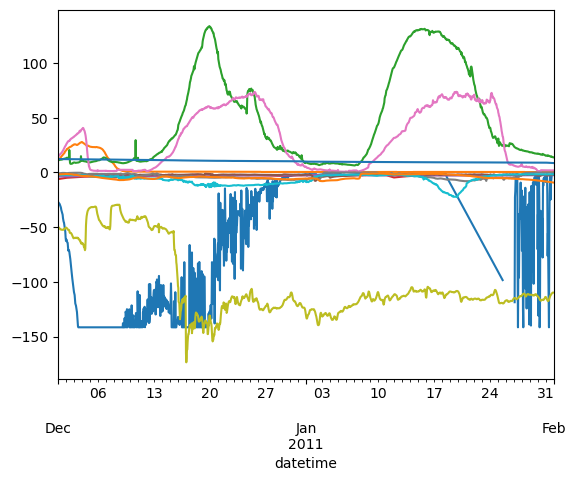

In [1751]:
for station in stations:
    print(station)
    station_discharge[station].plot()

# Compare with river files

In [2707]:
# found these by visual inspection of the `river_transport` variable which has negative signs on the
# 0s so I could read them off there.
river_sign = [-1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 
              -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
              -1, -1, -1, -1, -1, -1, -1, -1, -1, 1,
              1, 1, 1, 1, 1, 1]

stations = ['15276000', '15290000', '15271000', '15239900', '15281000', '15295700',
            '15239070', '15275100', '15266300', '15284000', '15292780', '15274600']

station_list_file = ['15295700', '15239070', '15239900', '15266300', '15266300',
                     '15271000', '15274600', '15275100', '15276000', '15281000',
                     '15281000', '15281000', '15281000', '15281000', '15281000',
                     '15281000', '15281000', '15281000', '15281000', '15284000',
                     '15284000', '15284000', '15284000', '15284000', '15284000',
                     '15284000', '15284000', '15284000', '15284000', '15290000',
                     '15290000', '15292780', '15292780', '15292780', '15292780', '15292780']

# station "in model": station actually used
discharge_stations = {'15276000': "15276000", '15290000': "15290000", 
                      '15271000': "15271000", '15239900': "15239900", 
                      '15281000': "15281000", '15295700': "15295700",
                      '15239070': "15239070", '15275100': "15275100", 
                      '15266300': "15266300", '15284000': "15284000", 
                      '15292780': "15292000", '15274600': "15274600"}

# station "in model": station actually used
temp_stations = {'15276000': "15276000", '15290000': "15290000", 
                      '15271000': "15258000", '15239900': "15239900", 
                      '15281000': "15284000", '15295700': "15295700",
                      '15239070': "15239070", '15275100': "15276000", 
                      '15266300': "15266300", '15284000': "15284000", 
                      '15292780': "15292780", '15274600': "15276000"}

nsrho = 30  # number depths
nrivers = len(station_list_file) 


In [2978]:
def create_river_forcing_file(start, end, ndays, window=24, skip_last=False):
        
    # create arrays to input in the netcdf files
    index = pd.date_range(start.replace("Z",""), end.replace("Z",""), freq="1H")

    if skip_last:
        index = index[:-1]
        end = index[-1].isoformat()[:16]
    ntimes = len(index)

    # get river data for the time period
    station_discharge, station_temp = {}, {}
    for station in discharge_stations.values():
        station_discharge[station] = find_discharge(station, start, end, ndays, window=window)
    for station in temp_stations.values():
        station_temp[station] = find_temp(station, start, end, ndays, window=window)

    river_transport = np.zeros((ntimes, nrivers))
    river_temp = np.zeros((ntimes, nsrho, nrivers))

    # stations are repeated in a certain order in station_list_file
    for i, station_file in enumerate(station_list_file):
        if discharge_stations[station_file] == "15292780":
            factor = 2
        else:
            factor = 1
        nrepeats = station_list_file.count(station_file)
        river_transport[:,i] = factor*river_sign[i]*station_discharge[discharge_stations[station_file]]/nrepeats
        river_temp[:,:,i] = station_temp[temp_stations[station_file]].values[:,np.newaxis].repeat(nsrho, axis=1)

    # create netcdf files starting from the acquired data
    loc = 'nos.ciofs.river.20221216.t00z (1).nc'
    ds = xr.open_dataset(loc)
    
    vars_to_keep = ["river_names", "river_Xposition", "river_Eposition", "river_direction",
    "river_flag", "river_sign", "river_Vshape"]
    dsnew = ds[vars_to_keep].copy(deep=True)

    # add new variables that include time
    dsnew["river_time"] = ("time", index)
    dsnew["river_transport"] = (("time","river"), river_transport)
    dsnew["river_transport"] = dsnew["river_transport"].astype(np.float32)
    dsnew["river_temp"] = (("time","s_rho","river"), river_temp)
    dsnew["river_temp"] = dsnew["river_temp"].astype(np.float32)
    dsnew["river_salt"] = xr.full_like(dsnew["river_temp"], 0.005)
    dsnew["river_pass"] = xr.full_like(dsnew["river_temp"], 9.96921e+36)
    new_vars = ["river_time", "river_transport", "river_temp", "river_salt", "river_pass"]
    for var in new_vars:
        dsnew[var].attrs = ds[var].attrs
    
    # Update global attributes
    dsnew.attrs["data_source"] = "River discharge from USGS real time, estimated using gage height and rating curve, or from daily statistical mean."
    dsnew.attrs["Temp_source"] = "River T from USGS real time or daily statistical mean."
    dsnew.attrs["Salt_source"] = "Always 0.005"
    dsnew.attrs["institution"] = "Axiom Data Science"
    now = str(pd.Timestamp.now())
    dsnew.attrs["history"] = f"Created {now}. Run using `dataretrieval-python` package and code from Axiom Data Science."
    fname = pd.Timestamp(start).strftime("axiom.ciofs.river.%Y%m%d.nc")
    dsnew.attrs["output_file"] = f"River Forcing file: {fname}"
    dsnew.attrs["source_code"] = "Created using Axiom Data Science software."
    dsnew.attrs["reference"] = "Created by Kristen M. Thyng, Axiom Data Science."

    return dsnew, fname


# Make monthly forcing files for 1998 and check them

In [2996]:


# start_overall, end_overall = "1998-1-1T00:00", "1998-12-31T23:00"
year = 1998
for i in range(1,2):
    if i == 12:
        start, end = f"{year}-{i}-1T00", f"{year+1}-{1}-1T00"
    else:
        start, end = f"{year}-{i}-1T00", f"{year}-{i+1}-1T00"

    ds, fname = create_river_forcing_file(start, end, ndays=8, skip_last=True)
    ds.to_netcdf(fname)


Processing discharge for station 15276000 from 1998-1-1T00 to 1998-01-31T23:00.
Accessed discharge data.
Accessed gage data.
Gage dataset is empty. Use mean time series.
calculating mean time series
fill consecutive nan gaps of over 8 days with function <function discharge_from_gage_or_mean at 0x7fe326134b80>.
Dates replaced: DatetimeIndex(['1998-01-01 00:00:00', '1998-01-01 00:15:00',
               '1998-01-01 00:30:00', '1998-01-01 00:45:00',
               '1998-01-01 01:00:00', '1998-01-01 01:15:00',
               '1998-01-01 01:30:00', '1998-01-01 01:45:00',
               '1998-01-01 02:00:00', '1998-01-01 02:15:00',
               ...
               '1998-01-30 06:30:00', '1998-01-30 06:45:00',
               '1998-01-30 07:00:00', '1998-01-30 07:15:00',
               '1998-01-30 07:30:00', '1998-01-30 07:45:00',
               '1998-01-30 08:00:00', '1998-01-30 08:15:00',
               '1998-01-30 08:30:00', '1998-01-30 08:45:00'],
              dtype='datetime64[ns]', leng